## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from datetime import datetime
import seaborn as sns


#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Modelos
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score, mean_squared_error

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

# copiando sidmodel porque ele não estava escrevendo a ordem correta dos modelos
from copy import copy, deepcopy

#statsmodels for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# import scienceplots
# plt.style.use(['science', 'ieee', 'notebook'])
plt.style.use(['seaborn-v0_8-whitegrid'])
# plt.style.use(['seaborn-whitegrid'])


c:\Users\bewm\AppData\Roaming\Python\env\env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importando os dados

Recovering from picke, comment if not necessary

In [3]:
# prefix = 'DECV1.MISO.W1_L'
# binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
# print(binary)

# with open(binary, 'rb') as bin_file:
#     X1_tr, y_tr, X1_te, y_te, results_dict, df2 = pickle.load(bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\outputs\DECV1.MISO.W1_L_ml.pkl


### Lendo dados

In [5]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\data\volve_compiled.pkl


In [6]:
for wellp in data['OP'].keys():
    print(wellp)


15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


# Selecionando dados

In [7]:
# case = "15/9-F-14"
case = "15/9-F-1 C"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


# Plotando dados

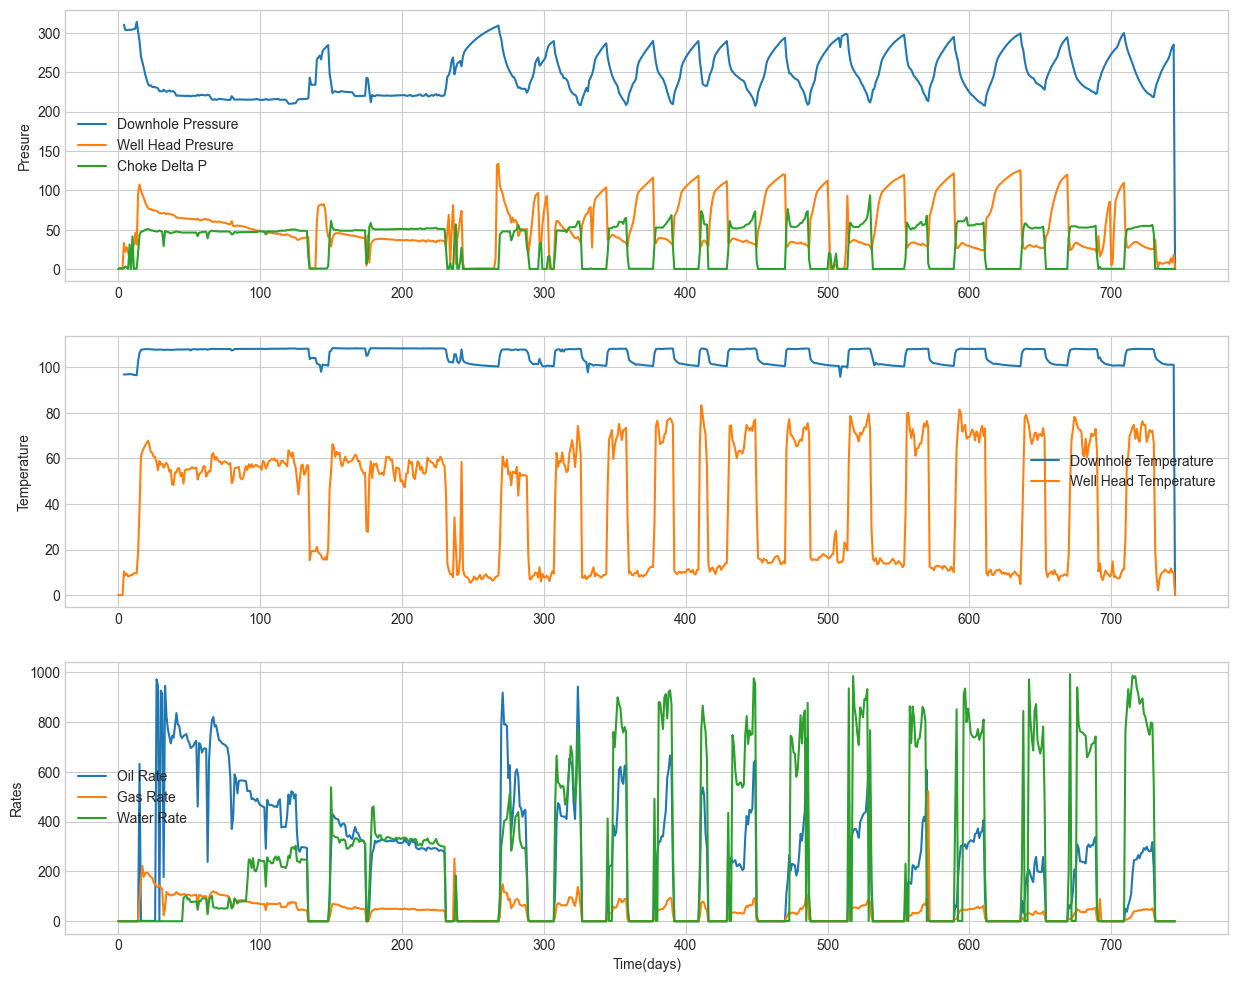

In [8]:
time = data_case['N']

plot_dict_P = {
'AVG_DOWNHOLE_PRESSURE':'Downhole Pressure',
'AVG_WHP_P':'Well Head Presure',
# 'AVG_DP_TUBING':'Tubing Delta P',
# 'AVG_ANNULUS_PRESS':'Annulus Pressure',
'AVG_CHOKE_SIZE_P':'Choke Delta P',
# 'DP_CHOKE_SIZE':'DP_CHOKE_SIZE_P',
}
plot_dict_T = {
'AVG_DOWNHOLE_TEMPERATURE':'Downhole Temperature',
'AVG_WHT_P':'Well Head Temperature',
}
plot_dict_Q = {
'BORE_OIL_VOL':'Oil Rate',
'BORE_GAS_VOL':'Gas Rate',
'BORE_WAT_VOL':'Water Rate',
}

fig, ax = plt.subplots(3,1, figsize=(15,12))

for k,v in plot_dict_P.items():
    ax[0].plot(time, data_case[k], label=v)

for k,v in plot_dict_T.items():
    ax[1].plot(time, data_case[k], label=v)

for k,v in plot_dict_Q.items():
    ax[2].plot(time, data_case[k], label=v)

ax[0].legend(fontsize='10')
ax[0].set_ylabel('Presure')

ax[1].legend(fontsize='10')
ax[1].set_ylabel('Temperature')

ax[2].legend(fontsize='10')
ax[2].set_xlabel('Time(days)')
ax[2].set_ylabel('Rates')


# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '0_well_data.eps')
# fig.savefig(p, format='eps')
pass;


In [9]:
data_case = data_case.iloc[28:,:]
data_case = data_case[filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values


# Seasonal decompose

Sem decompor as entradas por enquanto


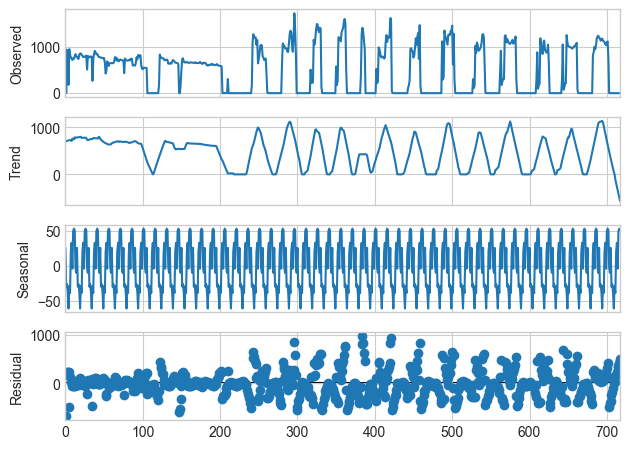

In [10]:
result = seasonal_decompose(y, model='additive', period=15, extrapolate_trend='freq')
fig = result.plot()
yt=result.trend.reshape(-1,1)
ys=result.seasonal.reshape(-1,1)
yr=result.resid.reshape(-1,1)

fig.axes[0].set_ylabel('Observed')
fig.axes[0].set_title('')

pass;


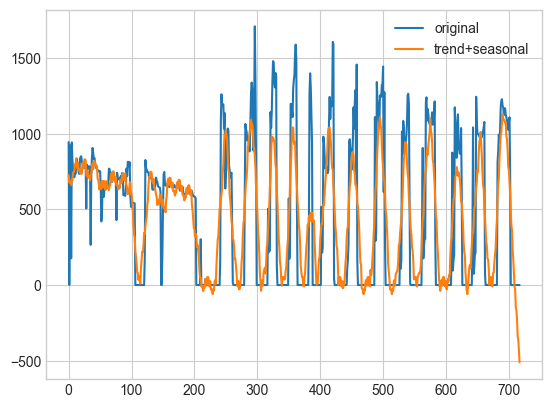

In [11]:
plt.plot(y, label='original')
plt.plot(yt+ys, label='trend+seasonal')
plt.legend()


# Preparação dos dodos

### Definindo a parcela de treino e de teste

In [12]:
p_train = 0.7 #70% treino


### Separando os conjuntos

In [13]:
n_train = int(X1.shape[0]*p_train)

X1_tr = X1[:n_train,:]
X1_te = X1[:,:]

y_tr = y[:n_train,:]
y_te = y[:,:]


In [14]:
print(
    X1.shape,
    X1_tr.shape,
    X1_te.shape
)
print(
    y.shape,
    y_tr.shape,
    y_te.shape,
)


(718, 5) (502, 5) (718, 5)
(718, 1) (502, 1) (718, 1)


### Removendo a escala 

In [15]:
s = MinMaxScaler()
X_tr = s.fit_transform(X1_tr)
X_te = s.fit_transform(X1_te)

y_tr = s.fit_transform(y_tr)
y_te = s.fit_transform(y_te)


# Declarando os modelos 

In [16]:
models = []


### Modelos de ML (sklearn)

#### Modelos

In [17]:
models_ml = [
    ('LinReg'             ,      LinearRegression(copy_X=True)), #ARX Equivalet
    ('RidgeReg'           ,      Ridge()),
    ('PolyReg'            ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivale)t
    ('SVM'                ,      SVR(max_iter=-1)),
    ('KNN'                ,      KNeighborsRegressor()),
    ('MLP'                ,      MLPRegressor(random_state=rs)),
    ('DecisionTree'       ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'       ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting'   ,      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'         ,      ExtraTreesRegressor(random_state=rs)),
    ('AdaBoostRegressor'  ,      AdaBoostRegressor(random_state=rs)),
    ('BaggingRegressor'   ,      BaggingRegressor(random_state=rs)),
    ('LightGBM'           ,      lgb.LGBMRegressor()),
    ('XGBoost'            ,      xgb.XGBRegressor()),
]

for i, m in enumerate(models_ml):
    # print (m[0])
    print (i, m[0])


0 LinReg
1 RidgeReg
2 PolyReg
3 SVM
4 KNN
5 MLP
6 DecisionTree
7 RandomForest
8 GradientBoosting
9 ExtraTrees
10 AdaBoostRegressor
11 BaggingRegressor
12 LightGBM
13 XGBoost


#### Parâmetros (RandomSearchCV)

In [18]:

parameters = [
    { # LinReg 0
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RidgeReg 1
        'positive'                     : [True, False],
    },
    { # PolyReg NARX 3
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # SVM 4
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # KNN 5
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # MLP 6
        'activation'            : ['relu', 'tanh'],
        'early_stopping'        : [True],
        'learning_rate_init'    : stats.loguniform(1e-4, 0.01),
        # 'learning_rate'         : ['adaptive', 'constant'],
        'alpha'                 : stats.loguniform(1e-5, 1e-3),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 60], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 60], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 60], repeat=3)],
        # 'max_iter'              : [10000],#stats.randint(200,10000),
        # 'batch_size'            : [32],
        # 'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),
    },
    { # DecisionTree 7
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RandomForest 8
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # GradientBoosting 9
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # ExtraTrees 10
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # AdaBoostRegressor 11
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 10),
        'loss'                      : ['linear', 'square', 'exponential'],
    },
    { # BaggingRegressor 12
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'max_samples'               : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_features'              : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'bootstrap'                 : [True, False],      #maxima quantidade de features para embasar a decisao de divisao
    },
    { # LightGBM 13
        'num_leaves'                : stats.randint(5,100), # max num folhas dos base learners
        'n_estimators'              : stats.randint(10,200), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 1),
        # 'max_depth'                 : stats.randint(1,20), #maxima profundidade da arvore
    },
    { # XGBoost 14
        'n_estimators'           : stats.randint(2,100), #Numero de arvores
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'learning_rate'          : stats.loguniform(1e-3, 1),
    },
]


### Setando Kfold e Random Search

In [19]:
kfolds = 5
niters = 3
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)


In [20]:
n_iter = 30 #Numero de iterações do rdmsearch
models = []
for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', param_distributions=params, n_iter=n_iter, n_jobs=6, cv=rkf, random_state=rs)

    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch,
        )

    models.append(
        (model[0], sidmodel)
    )


# Treinamento

## Escolha dos modelos

In [21]:
# 0 LinReg
# 1 RidgeReg
# 2 PolyReg
# 3 SVM
# 4 KNN
# 5 MLP
# 6 DecisionTree
# 7 RandomForest
# 8 GradientBoosting
# 9 ExtraTrees
# 10 AdaBoostRegressor
# 11 BaggingRegressor
# 12 LightGBM
# 13 XGBoost
models_choice = [0,1,2,4,5,7,8,11,13]
# models_choice = [2,13]
# models_choice = [0,1]
for model in np.array(models)[models_choice]:
    print (model[0])


LinReg
RidgeReg
PolyReg
KNN
MLP
RandomForest
GradientBoosting
BaggingRegressor
XGBoost


## Escolha das ordens

In [22]:
orders = [2, 3, 6, 12, 15, 20]
# orders = [12]


In [53]:
results_dict = {
    'MODEL1':[],
    'MODEL2':[],
    'ORDER':[],
    'R2_TRAIN_OSA':[],
    'R2_TEST_OSA':[],
    'R2_TRAIN_FS':[],
    'R2_TEST_FS':[],
    'RMSE_TRAIN_OSA':[],
    'RMSE_TEST_OSA':[],
    'RMSE_TRAIN_FS':[],
    'RMSE_TEST_FS':[],
    'MODEL_OBJ1':[],
    'MODEL_OBJ2':[],
}


## Looping de treinamento e calculo das metricas

In [54]:
t00 = datetime.now()

#Loop principal, iterando sobre as listas
for order in orders:
    print(f'Order {order}')

    t0 = datetime.now()

    for model in np.array(models)[models_choice]:

        # Training Step 1: full training set
        model_name, sidmodel = model
        print(f'Training Step 1: {model_name} ', end='')
        sidmodel.nX = order
        sidmodel.ny = order

        # train
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)

        # predictions
        y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
        y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
        y_hat_te_fs  = sidmodel.predict(X1_te, y=y_te )
        y_hat_tr_fs  = sidmodel.predict(X1_tr, y=y_tr )

        # score
        r2_tr_osa = r2_score(y_tr,  y_hat_tr_osa)
        r2_te_osa = r2_score(y_te,  y_hat_te_osa)
        rmse_tr_osa = mean_squared_error(y_tr, y_hat_tr_osa)**0.5
        rmse_te_osa = mean_squared_error(y_te, y_hat_te_osa)**0.5
        try:
            r2_tr_fs = r2_score(y_tr, y_hat_tr_fs)
            r2_te_fs = r2_score(y_te, y_hat_te_fs)
            rmse_tr_fs = mean_squared_error(y_tr, y_hat_tr_fs)**0.5
            rmse_te_fs = mean_squared_error(y_te, y_hat_te_fs)**0.5
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
            rmse_tr_fs = 1e290
            rmse_te_fs = 1e290

        # save and write
        results_dict['MODEL1'].append(model_name)
        results_dict['MODEL2'].append('-')
        results_dict['ORDER'].append(order)
        results_dict['R2_TRAIN_OSA'].append(r2_tr_osa)
        results_dict['R2_TEST_OSA'].append(r2_te_osa)
        results_dict['R2_TRAIN_FS'].append(r2_tr_fs)
        results_dict['R2_TEST_FS'].append(r2_te_fs)
        results_dict['RMSE_TRAIN_OSA'].append(rmse_tr_osa)
        results_dict['RMSE_TEST_OSA'].append(rmse_te_osa)
        results_dict['RMSE_TRAIN_FS'].append(rmse_tr_fs)
        results_dict['RMSE_TEST_FS'].append(rmse_te_fs)
        results_dict['MODEL_OBJ1'].append(deepcopy(sidmodel))
        results_dict['MODEL_OBJ2'].append(None)
        print(f'\t\tR2.OSA(Test)={r2_te_osa:.4f}, R2.FS(Test)={r2_te_fs:.4f}')

        # ###################################################
        # Training Step 2: training on train set residuals
        # ###################################################

        # residuals
        yr_tr = y_tr - y_hat_tr_osa
        yr_te = y_te - y_hat_te_osa

        for model_res in np.array(models)[models_choice]:
            model_name_res, sidmodel_res  = model_res
            print(f'\t Step 2: +{model_name_res}', end='')
            sidmodel_res.nX = order
            sidmodel_res.ny = order

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sidmodel_res.fit(X=X1_tr, y=yr_tr)

            # predictions
            yr_hat_te_osa = sidmodel_res.predict(X1_te, y=yr_te, steps_ahead=1)
            yr_hat_tr_osa = sidmodel_res.predict(X1_tr, y=yr_tr, steps_ahead=1)
            try:
                yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
                yr_hat_tr_fs  = sidmodel_res.predict(X1_tr, y=yr_tr)
            except ValueError:
                yr_hat_te_fs  = np.zeros(len(y_te))
                yr_hat_tr_fs  = np.zeros(len(y_te))
            # combined (final) predictions
            yf_hat_tr_osa = y_hat_tr_osa + yr_hat_tr_osa
            yf_hat_te_osa = y_hat_te_osa + yr_hat_te_osa
            yf_hat_tr_fs = y_hat_tr_fs + yr_hat_tr_fs
            yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs

            # score
            r2f_tr_osa = r2_score(y_tr,  yf_hat_tr_osa)
            r2f_te_osa = r2_score(y_te,  yf_hat_te_osa)
            rmsef_tr_osa = mean_squared_error(y_tr, yf_hat_tr_osa)**0.5
            rmsef_te_osa = mean_squared_error(y_te, yf_hat_te_osa)**0.5
            try:
                r2f_tr_fs = r2_score(y_tr, yf_hat_tr_fs)
                r2f_te_fs = r2_score(y_te, yf_hat_te_fs)
                rmsef_tr_fs = mean_squared_error(y_tr, yf_hat_tr_fs)**0.5
                rmsef_te_fs = mean_squared_error(y_te, yf_hat_te_fs)**0.5
            except ValueError:
                r2f_tr_fs = 1e290
                r2f_te_fs = 1e290
                rmsef_tr_fs = 1e290
                rmsef_te_fs = 1e290

            results_dict['MODEL1'].append(model_name)
            results_dict['MODEL2'].append(model_name_res)
            results_dict['ORDER'].append(order)
            results_dict['R2_TRAIN_OSA'].append(r2f_tr_osa)
            results_dict['R2_TEST_OSA'].append(r2f_te_osa)
            results_dict['R2_TRAIN_FS'].append(r2f_tr_fs)
            results_dict['R2_TEST_FS'].append(r2f_te_fs)
            results_dict['RMSE_TRAIN_OSA'].append(rmsef_tr_osa)
            results_dict['RMSE_TEST_OSA'].append(rmsef_te_osa)
            results_dict['RMSE_TRAIN_FS'].append(rmsef_tr_fs)
            results_dict['RMSE_TEST_FS'].append(rmsef_te_fs)
            results_dict['MODEL_OBJ1'].append(deepcopy(sidmodel))
            results_dict['MODEL_OBJ2'].append(deepcopy(sidmodel_res))
            print(f'\t\tR2.OSA(Test)={r2f_te_osa:.4f}, R2.FS(Test)={r2f_te_fs:.4f}, R2 Increase={100*(r2f_te_fs/r2_te_fs-1):.1f}%')
        print()
    print(f'Tempo (ordem): {datetime.now()-t0}\nTempo (acum): {datetime.now()-t00}\n')


Order 2
Training Step 1: LinReg 

		R2.OSA(Test)=0.7869, R2.FS(Test)=0.5883
	 Step 2: +LinReg		R2.OSA(Test)=0.7882, R2.FS(Test)=0.5885, R2 Increase=0.0%
	 Step 2: +RidgeReg		R2.OSA(Test)=0.7882, R2.FS(Test)=0.5883, R2 Increase=-0.0%
	 Step 2: +PolyReg		R2.OSA(Test)=0.7923, R2.FS(Test)=0.6025, R2 Increase=2.4%
	 Step 2: +KNN		R2.OSA(Test)=0.9228, R2.FS(Test)=0.6701, R2 Increase=13.9%
	 Step 2: +MLP		R2.OSA(Test)=0.7344, R2.FS(Test)=0.5286, R2 Increase=-10.2%
	 Step 2: +RandomForest		R2.OSA(Test)=0.8508, R2.FS(Test)=0.6361, R2 Increase=8.1%
	 Step 2: +GradientBoosting		R2.OSA(Test)=0.8635, R2.FS(Test)=0.6516, R2 Increase=10.8%
	 Step 2: +BaggingRegressor		R2.OSA(Test)=0.8786, R2.FS(Test)=0.6523, R2 Increase=10.9%
	 Step 2: +XGBoost		R2.OSA(Test)=0.8420, R2.FS(Test)=0.6352, R2 Increase=8.0%

Training Step 1: RidgeReg 		R2.OSA(Test)=0.7876, R2.FS(Test)=0.6099
	 Step 2: +LinReg		R2.OSA(Test)=0.7893, R2.FS(Test)=0.6110, R2 Increase=0.2%
	 Step 2: +RidgeReg		R2.OSA(Test)=0.7885, R2.FS(Test)=0.6128, R2 Increase=0.5%
	 Step 2: 

In [23]:
df = pd.DataFrame(results_dict)
df.sort_values('R2_TEST_FS')


,MODEL1,MODEL2,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2
35,KNN,MLP,2,-407.407980,-4.217428e+02,-3.912311e+02,-4.075647e+02,5.333042e+00,5.622129,5.226355e+00,5.527047e+00,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
451,LinReg,LinReg,20,0.833231,8.083558e-01,-6.544723e-01,-2.218336e+00,1.077669e-01,0.119705,3.394358e-01,4.905445e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
400,MLP,-,15,0.410147,4.512294e-01,3.196499e-01,3.548880e-01,2.026748e-01,0.202562,2.176677e-01,2.196243e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None
461,RidgeReg,LinReg,20,0.824877,7.982697e-01,3.582535e-01,3.588157e-01,1.104333e-01,0.122814,2.114023e-01,2.189547e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
170,XGBoost,-,3,0.909575,8.721696e-01,4.671468e-01,4.207148e-01,7.935467e-02,0.097764,1.926334e-01,2.081177e-01,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,RandomForest,PolyReg,15,0.948228,7.928120e-01,1.000000e+290,1.000000e+290,6.004498e-02,0.124464,1.000000e+290,1.000000e+290,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
473,PolyReg,PolyReg,20,0.905332,7.857183e-01,1.000000e+290,1.000000e+290,8.119515e-02,0.126577,1.000000e+290,1.000000e+290,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
423,GradientBoosting,PolyReg,15,0.936118,6.392318e-01,1.000000e+290,1.000000e+290,6.669876e-02,0.164239,1.000000e+290,1.000000e+290,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
513,GradientBoosting,PolyReg,20,0.949490,-1.027495e-01,1.000000e+290,1.000000e+290,5.930854e-02,0.287145,1.000000e+290,1.000000e+290,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


Trocando valores expurios por NaN

In [24]:
df2 = df.copy()
df2.loc[df['R2_TEST_FS']<-2, ['R2_TRAIN_OSA','R2_TEST_OSA','R2_TRAIN_FS','R2_TEST_FS']] = np.nan
df2.loc[df['R2_TEST_FS']>1e6, ['R2_TRAIN_OSA','R2_TEST_OSA','R2_TRAIN_FS','R2_TEST_FS','RMSE_TRAIN_FS','RMSE_TEST_FS']] = np.nan
df2.sort_values('R2_TEST_FS')


,MODEL1,MODEL2,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2
400,MLP,-,15,0.410147,0.451229,0.319650,0.354888,0.202675,0.202562,0.217668,0.219624,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None
461,RidgeReg,LinReg,20,0.824877,0.798270,0.358254,0.358816,0.110433,0.122814,0.211402,0.218955,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
170,XGBoost,-,3,0.909575,0.872170,0.467147,0.420715,0.079355,0.097764,0.192633,0.208118,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None
178,XGBoost,BaggingRegressor,3,0.915278,0.871758,0.478772,0.421047,0.076812,0.097921,0.190520,0.208058,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
179,XGBoost,XGBoost,3,0.940086,0.887281,0.481591,0.428979,0.064594,0.091804,0.190005,0.206628,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,MLP,PolyReg,20,NaN,NaN,NaN,NaN,0.114233,0.131123,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
503,RandomForest,PolyReg,20,NaN,NaN,NaN,NaN,0.064170,0.112810,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
513,GradientBoosting,PolyReg,20,NaN,NaN,NaN,NaN,0.059309,0.287145,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
523,BaggingRegressor,PolyReg,20,NaN,NaN,NaN,NaN,0.037542,0.263845,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


Criando Flag de treinamento em 2 steps

In [25]:
df2['STEPS'] = '2'
df2.loc[df2['MODEL2']=='-', ['STEPS']] = '1'
df2.value_counts('STEPS')


STEPS
2    486
1     54
dtype: int64

Renomenado modelos pra facilitar nos plots

In [26]:
df2.rename(columns={'MODEL1':'BASE_MODEL', 'MODEL2':'RESIDUAL_MODEL'}, inplace=True)


#### Salvando

In [251]:
prefix = 'DECV1.MISO.W1_L'
binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results_dict, df2), bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\outputs\DECV1.MISO.W1_L_ml.pkl


# Analysis

<Axes: xlabel='ORDER', ylabel='R2_TEST_FS'>

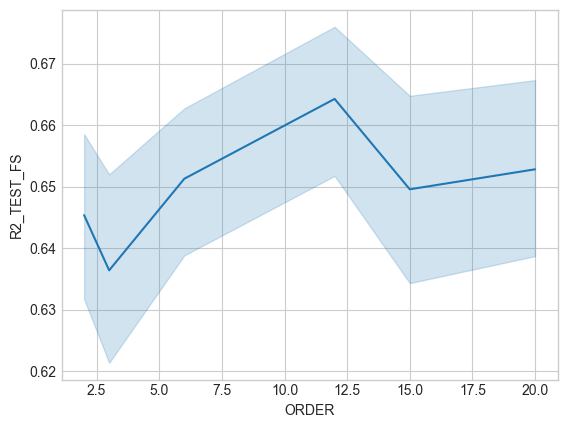

In [27]:
sns.lineplot(data=df2, x='ORDER', y='R2_TEST_FS')


<Axes: xlabel='R2_TEST_FS', ylabel='Density'>

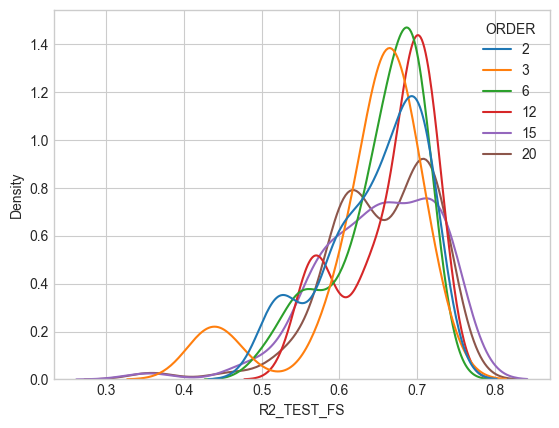

In [28]:
sns.kdeplot(data=df2, x='R2_TEST_FS', hue='ORDER', palette='tab10')


(0.4, 0.75)

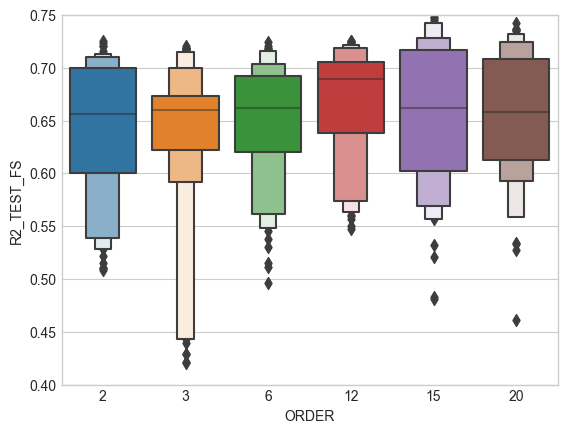

In [29]:
# sns.boxplot(data=df2, x='ORDER', y='R2_TEST_FS',showmeans=False, meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black", "markersize":8},)
sns.boxenplot(data=df2, x='ORDER', y='R2_TEST_FS')
plt.ylim([0.4,.75])


Reultados

(0.45, 0.75)

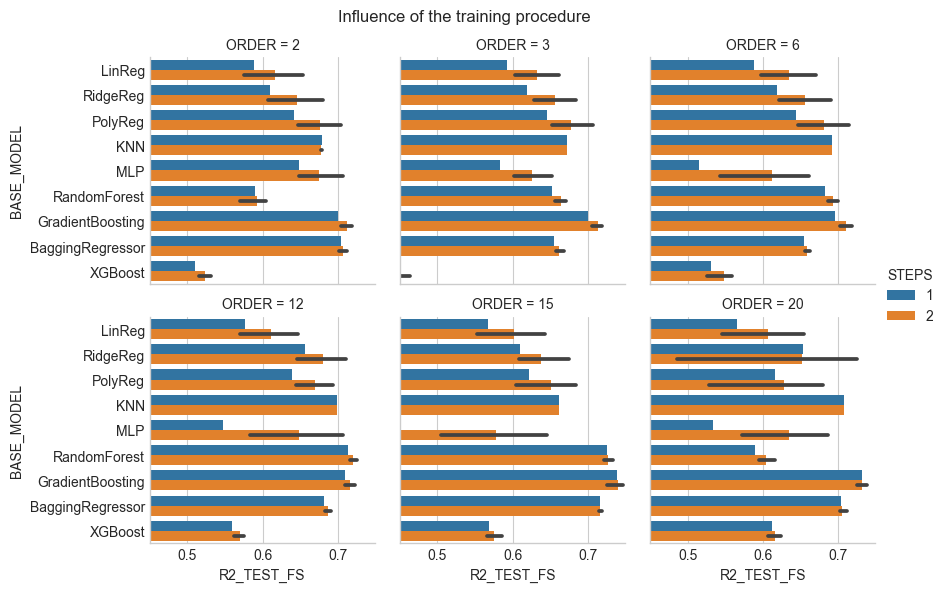

In [30]:
c = sns.catplot(data=df2, x='R2_TEST_FS', y='BASE_MODEL', hue='STEPS', col='ORDER', col_wrap=3, errorbar=('ci',100), kind='bar',  height=3, aspect=1 )
c.fig.suptitle('Influence of the training procedure', size=12)
c.fig.subplots_adjust(top=.9)
plt.xlim([.45,.75])


In [31]:
df2.columns


Index(['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TRAIN_OSA', 'R2_TEST_OSA',
       'R2_TRAIN_FS', 'R2_TEST_FS', 'RMSE_TRAIN_OSA', 'RMSE_TEST_OSA',
       'RMSE_TRAIN_FS', 'RMSE_TEST_FS', 'MODEL_OBJ1', 'MODEL_OBJ2', 'STEPS'],
      dtype='object')

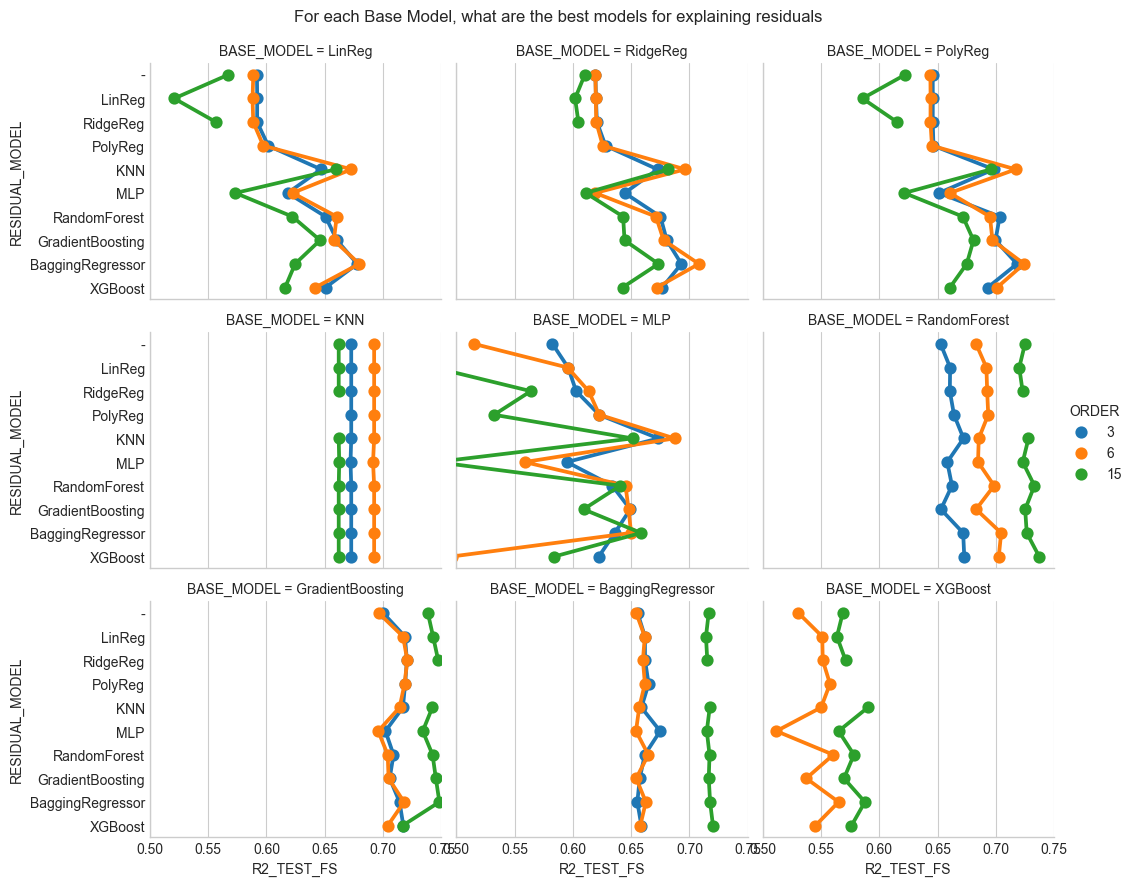

In [32]:

c = sns.catplot(data=df2[df2['ORDER'].isin([1,3,6,15])], x='R2_TEST_FS', y='RESIDUAL_MODEL', hue='ORDER', col='BASE_MODEL', col_wrap=3, errorbar=('ci',100), kind='point', height=3, aspect=1.2)
plt.xlim([.50,.75])
c.fig.suptitle(f'For each Base Model, what are the best models for explaining residuals')
c.fig.subplots_adjust(top=0.92)


Ranqueamento dos melhores casos

In [33]:
df_rank = df2.sort_values(by='R2_TEST_FS', ascending=False).drop_duplicates(subset=['BASE_MODEL', 'RESIDUAL_MODEL']).reset_index()
df_rank.to_clipboard()
df_rank.head(10)


,index,BASE_MODEL,RESIDUAL_MODEL,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2,STEPS
0,428,GradientBoosting,BaggingRegressor,15,0.985539,0.915605,0.772523,0.748329,0.031734,0.079437,0.125863,0.137176,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
1,422,GradientBoosting,RidgeReg,15,0.918423,0.871615,0.760991,0.747291,0.075372,0.097976,0.129013,0.137459,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
2,427,GradientBoosting,GradientBoosting,15,0.945233,0.891041,0.757767,0.745308,0.061757,0.090260,0.129881,0.137997,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
3,421,GradientBoosting,LinReg,15,0.920404,0.877226,0.755966,0.742954,0.074451,0.095811,0.130363,0.138633,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
4,426,GradientBoosting,RandomForest,15,0.941130,0.891858,0.753302,0.742477,0.064029,0.089921,0.131072,0.138762,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
5,424,GradientBoosting,KNN,15,1.000000,0.925518,0.753529,0.742312,0.000001,0.074626,0.131012,0.138807,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
6,420,GradientBoosting,-,15,0.909939,0.865462,0.749039,0.738447,0.079195,0.100296,0.132200,0.139844,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None,1
7,419,RandomForest,XGBoost,15,0.962960,0.905156,0.767554,0.737168,0.050788,0.084211,0.127230,0.140185,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
8,468,RidgeReg,BaggingRegressor,20,0.974149,0.898102,0.771339,0.736674,0.042430,0.087286,0.126190,0.140317,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
9,425,GradientBoosting,MLP,15,0.908066,0.864952,0.746195,0.734062,0.080014,0.100486,0.132947,0.141011,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2


Swarm Plots misturando as ordens

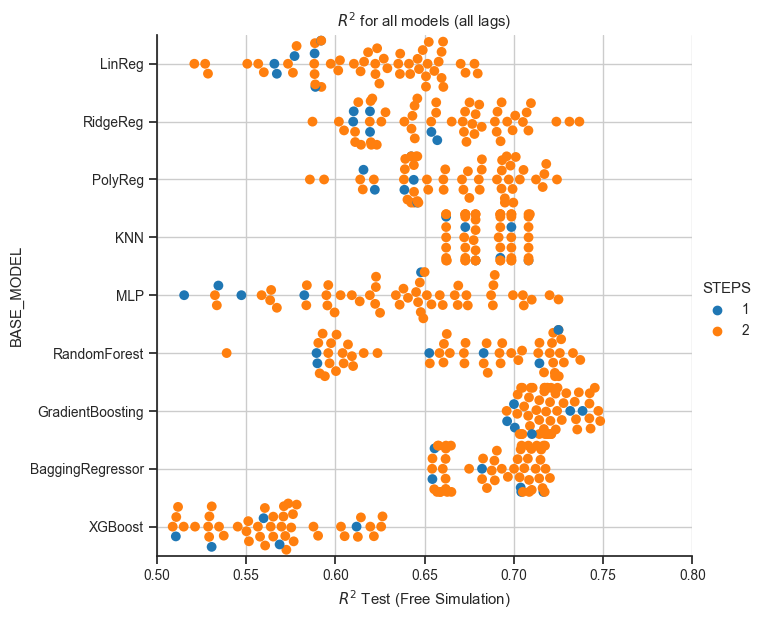

In [34]:

sns.set(font_scale=.9, style='ticks')

catplot = sns.catplot(data=df2, y='BASE_MODEL', x='R2_TEST_FS', hue='STEPS', kind='swarm', height=6, aspect=1.2, s=50, palette='tab10')
plt.xlim((.5,.8))
plt.grid()
plt.xlabel('$R^2$ Test (Free Simulation)')
plt.title('$R^2$ for all models (all lags)')
pass;

# fig = catplot.fig
# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '3_r2_swarm.eps')
# fig.savefig(p, format='eps')


ScatterPlot variando as ordens

In [35]:
df2.columns


Index(['BASE_MODEL', 'RESIDUAL_MODEL', 'ORDER', 'R2_TRAIN_OSA', 'R2_TEST_OSA',
       'R2_TRAIN_FS', 'R2_TEST_FS', 'RMSE_TRAIN_OSA', 'RMSE_TEST_OSA',
       'RMSE_TRAIN_FS', 'RMSE_TEST_FS', 'MODEL_OBJ1', 'MODEL_OBJ2', 'STEPS'],
      dtype='object')

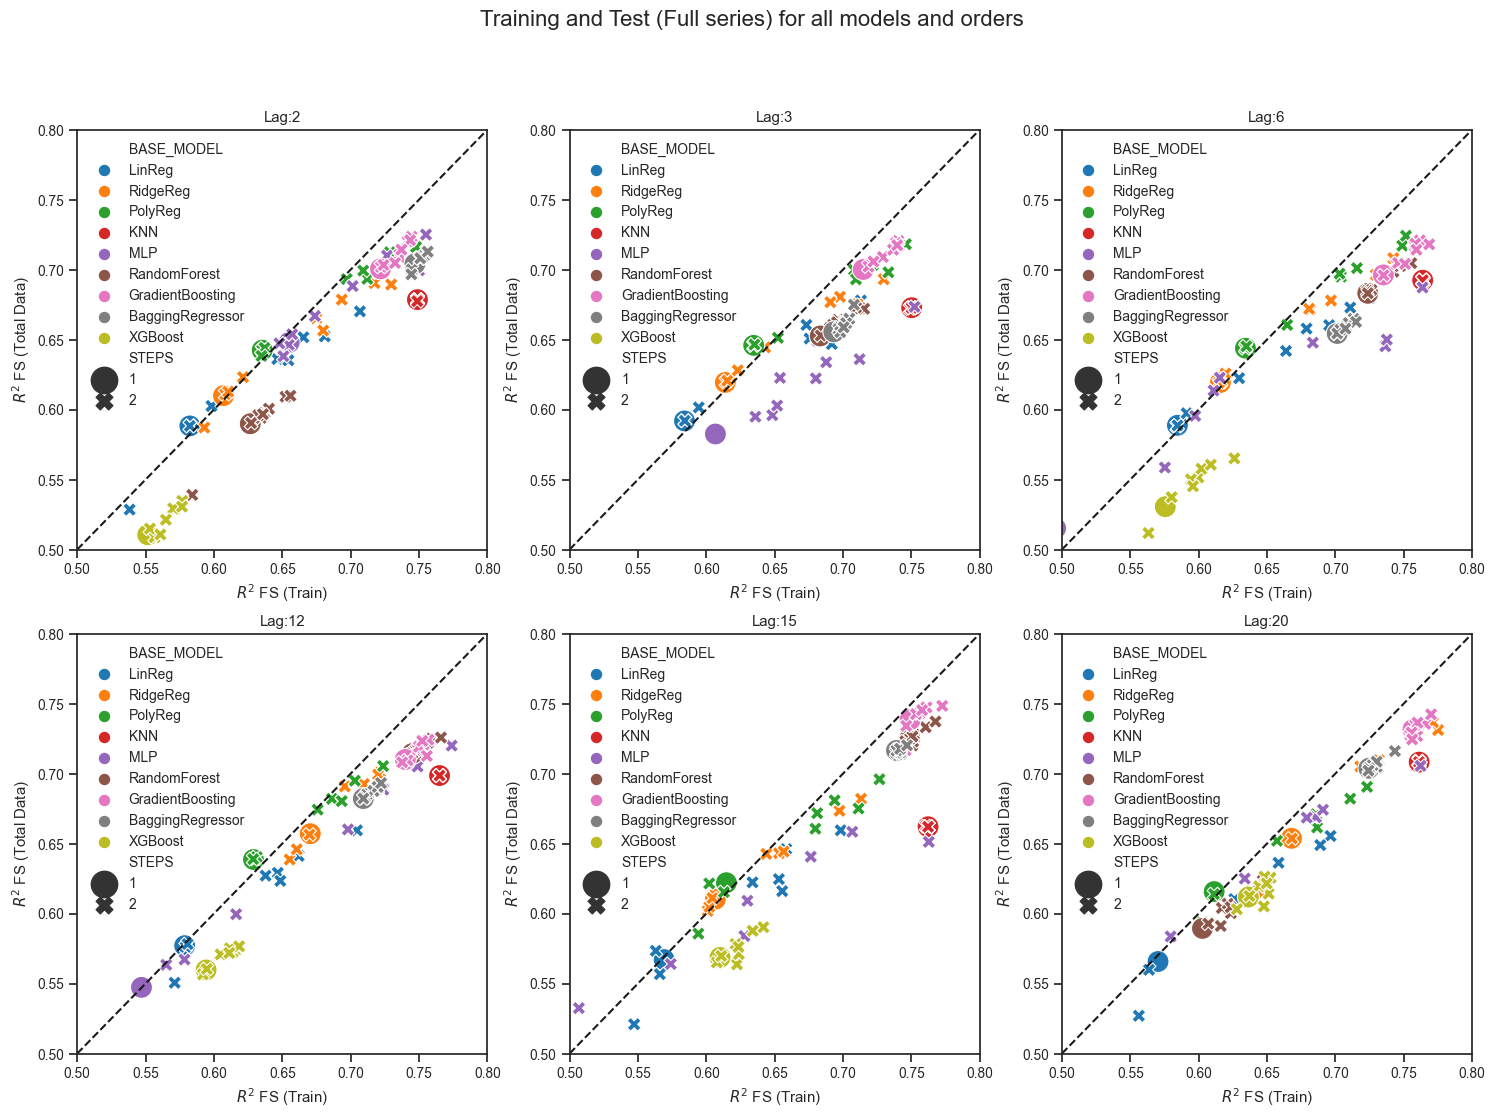

In [36]:
lim=(.5,.8)
fig, ax = plt.subplots(2,3, figsize=(18,12))

ax = ax.flatten()

fig.suptitle('Training and Test (Full series) for all models and orders', fontsize=16)

for i,o in enumerate (orders):
# for i,o in enumerate (orders[:-2]):
    sns.scatterplot(data=df2[df['ORDER']==o], x='R2_TRAIN_FS', y='R2_TEST_FS', hue='BASE_MODEL', ax=ax[i], size='STEPS', style='STEPS', sizes=(100,250), palette='tab10');
    ax[i].plot(lim, lim, '--', c='k')
    ax[i].set_xlim(lim)
    ax[i].set_ylim(lim)
    ax[i].set_title(f'Lag:{o}')
    ax[i].set_xlabel(f'$R^2$ FS (Train)')
    ax[i].set_ylabel(f'$R^2$ FS (Total Data)')
    ax[i].legend(fontsize=10, markerscale=1.2,)
pass;

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '4_results_scatter.eps')
# fig.savefig(p, format='eps')
#     ax[i].set_ylabel(f'$R^2$ FS (Test)')
# pass;


Predictions

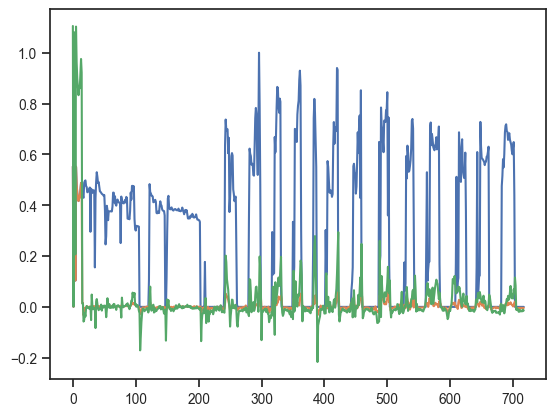

In [37]:
plt.plot(y_te)
best_pred = df_rank.loc[0,'MODEL_OBJ1'].predict(X1_te, y=y_te)
best_pred_r = df_rank.loc[0,'MODEL_OBJ2'].predict(X1_te, y=y_te)
plt.plot(best_pred)
plt.plot(best_pred+best_pred_r)
pass;


Treinando de novo o melhor modelo porque não consegui recuperar o objeto do modelo treinado que salvei no dataset

In [40]:
order = 15
_, sidmodel = models[8]
_, sidmodel_res = models[11]
sidmodel.nX = order
sidmodel.ny = order
sidmodel_res.nX = order
sidmodel_res.ny = order

# train
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel.fit(X=X1_tr, y=y_tr)

# predictions
y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
y_hat_te_fs = sidmodel.predict(X1_te, y=y_te)

# ###################################################
# Training Step 2: training on train set residuals
# ###################################################
# residuals
yr_tr = y_tr - y_hat_tr_osa
yr_te = y_te - y_hat_te_osa

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel_res.fit(X=X1_tr, y=yr_tr)

# predictions
yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
# combined (final) predictions
yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs


In [41]:
r2_score(y_te, y_hat_te_fs), r2_score(y_te, yf_hat_te_fs)


(0.7384473608538591, 0.74832935846365)

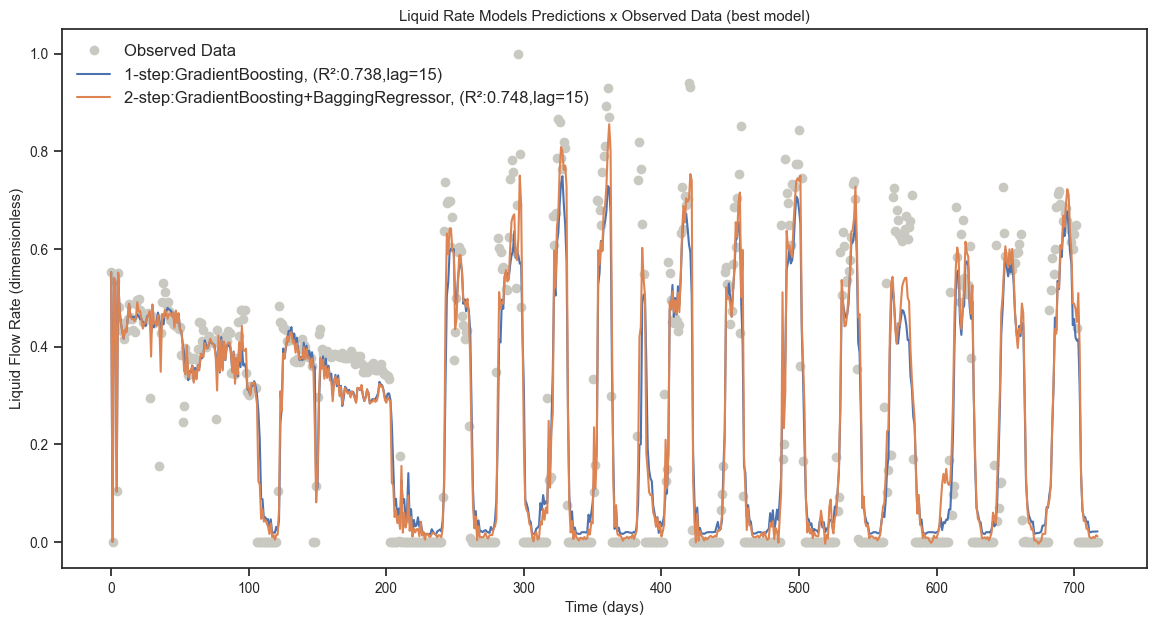

In [45]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(y_hat_te_fs, label=f"1-step:{df_rank.loc[6,'BASE_MODEL']}, (R²:{df_rank.loc[6,'R2_TEST_FS']:.3f},lag={df_rank.loc[0,'ORDER']})")
plt.plot(yf_hat_te_fs, label=f"2-step:{df_rank.loc[0,'BASE_MODEL']}+{df_rank.loc[0,'RESIDUAL_MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.3f},lag={df_rank.loc[0,'ORDER']})")
plt.legend()

plt.ylabel('Liquid Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data (best model)')

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '6_predictions_best_W1.eps')
# fig.savefig(p, format='eps')
pass;


Treinando agora um modelo linear onde o treinamento de residuos fez bastante diferenca

In [46]:
order = 2
_, sidmodel = models[1]
_, sidmodel_res = models[4]
sidmodel.nX = order
sidmodel.ny = order
sidmodel_res.nX = order
sidmodel_res.ny = order

# train
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel.fit(X=X1_tr, y=y_tr)

# predictions
y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
y_hat_te_fs = sidmodel.predict(X1_te, y=y_te)

# ###################################################
# Training Step 2: training on train set residuals
# ###################################################
# residuals
yr_tr = y_tr - y_hat_tr_osa
yr_te = y_te - y_hat_te_osa

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel_res.fit(X=X1_tr, y=yr_tr)

# predictions
yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
# combined (final) predictions
yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs


In [47]:
r2_score(y_te, y_hat_te_fs), r2_score(y_te, yf_hat_te_fs)


(0.6099286825922325, 0.6893179078699072)

In [53]:
df2[(df2['BASE_MODEL'] == 'RidgeReg') & (df2['ORDER'] == 2)].head(10)


,BASE_MODEL,RESIDUAL_MODEL,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2,STEPS
10,RidgeReg,-,2,0.799484,0.787613,0.606951,0.609929,1.181688e-01,0.126016,0.165444,0.170779,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None,1
11,RidgeReg,LinReg,2,0.800516,0.789349,0.608205,0.610963,1.178642e-01,0.125500,0.165180,0.170552,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
12,RidgeReg,RidgeReg,2,0.800335,0.788466,0.610424,0.612776,1.179177e-01,0.125763,0.164711,0.170155,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
13,RidgeReg,PolyReg,2,0.806475,0.791836,0.621274,0.623144,1.160904e-01,0.124757,0.162402,0.167861,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
14,RidgeReg,KNN,2,1.000000,0.921584,0.729583,0.689318,1.990601e-18,0.076571,0.137229,0.152413,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
15,RidgeReg,MLP,2,0.779095,0.765857,0.592945,0.587119,1.240313e-01,0.132313,0.168366,0.175701,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
16,RidgeReg,RandomForest,2,0.885694,0.854344,0.674788,0.665109,8.921985e-02,0.104358,0.150491,0.158239,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
17,RidgeReg,GradientBoosting,2,0.897235,0.861919,0.693446,0.678536,8.459628e-02,0.101608,0.146110,0.155035,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
18,RidgeReg,BaggingRegressor,2,0.923969,0.880374,0.717403,0.690336,7.276509e-02,0.094575,0.140285,0.152163,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
19,RidgeReg,XGBoost,2,0.874253,0.841367,0.679867,0.656447,9.357874e-02,0.108908,0.149311,0.160273,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2


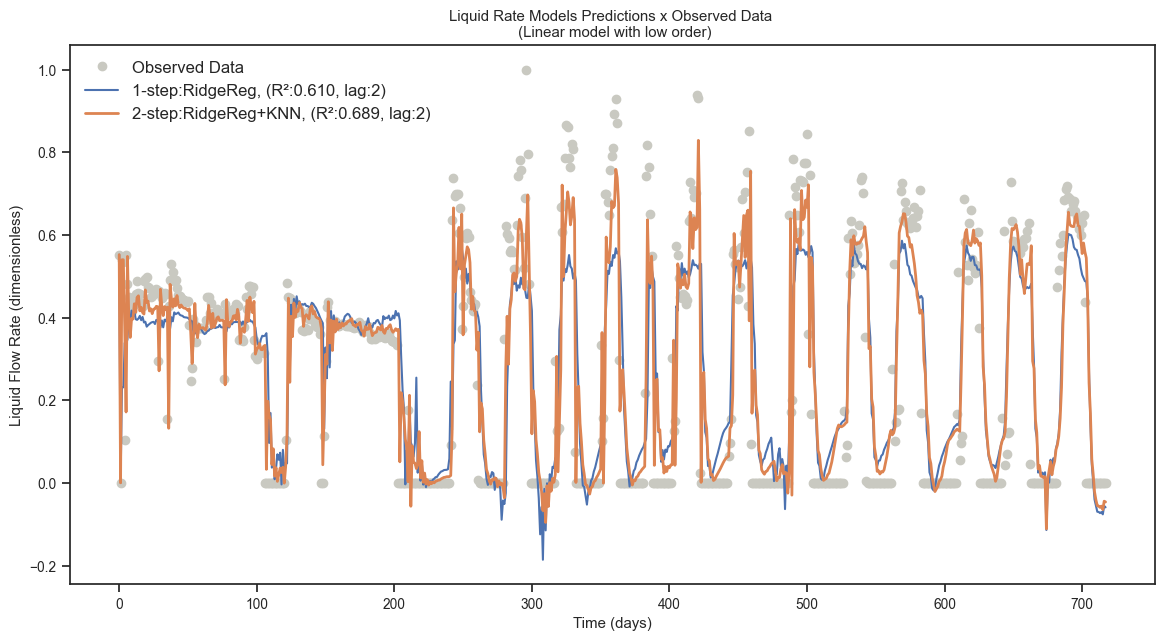

In [57]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(y_hat_te_fs, label=f"1-step:{df2.loc[10,'BASE_MODEL']}, (R²:{df2.loc[10,'R2_TEST_FS']:.3f}, lag:{df2.loc[14,'ORDER']})")
plt.plot(yf_hat_te_fs, label=f"2-step:{df2.loc[14,'BASE_MODEL']}+{df2.loc[14,'RESIDUAL_MODEL']}, (R²:{df2.loc[14,'R2_TEST_FS']:.3f}, lag:{df2.loc[14,'ORDER']})", lw=2)
plt.legend()

plt.ylabel('Liquid Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Liquid Rate Models Predictions x Observed Data \n (Linear model with low order)')

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '6_predictions_best_W1Lin.eps')
# fig.savefig(p, format='eps')
pass;


#### Estudos dos tempos e parametros (parei por aqui)

parametros dos melhores modelos

In [ ]:
for i,m in enumerate(df_rank['MODEL_OBJ']):
    print (i+1, end=',')
    if m.estimator.cv == 'prefit': #stack
        # print (m.estimator.final_estimator_.cv_results_['params'])
        print (m.estimator.final_estimator_.best_estimator_)
    else: #no stack
        # print (m.estimator.cv_results_['params'])
        print (m.estimator.best_estimator_)


In [ ]:
for i,m in enumerate(df_rank['MODEL_OBJ']):
    # print (i+1, end=',')
    if m.estimator.cv == 'prefit': #stack
        estim_cvr = m.estimator.final_estimator_.cv_results_
    else: #no stack
        estim_cvr = m.estimator.cv_results_
    print (f"{np.mean(estim_cvr['mean_fit_time'])*1000:.0f}")


# plt.plot(best_pred, label=f"{df_rank.loc[0,'MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.2f}, lag:{df_rank.loc[0,'ORDER']})")
